### Image Classification with EfficientNetB3 - Keras Hub (Expert Level)

This notebook demonstrates an expert-level image classification pipeline using the EuroSAT satellite image dataset.  



In [ ]:
import tensorflow as tf
import keras
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

### Load the EuroSAT satellite image dataset  
This cell loads the EuroSAT dataset, which contains satellite images across multiple land cover classes.  
It retrieves dataset info and class count for use in model setup.


In [ ]:
dataset, dataset_info = tfds.load("eurosat", as_supervised=True, with_info=True)
data_train, data_test = dataset["train"].batch(128), dataset["train"].batch(128)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/eurosat/rgb/incomplete.6A6UN6_2.0.0/eurosat-train.tfrecord*...:   0%|     …

Dataset eurosat downloaded and prepared to /root/tensorflow_datasets/eurosat/rgb/2.0.0. Subsequent calls will reuse this data.


### Apply strong data augmentation  
This block applies aggressive image augmentations such as flips, zooms, and contrast changes.  
It helps improve the model’s generalization to real-world image variations.


In [ ]:
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal_and_vertical"),
    keras.layers.RandomRotation(0.2),
    keras.layers.RandomZoom(0.2)
])

### Load EfficientNetB3 model from Keras Applications  
EfficientNetB3 is loaded without the top classification layer.  
The base model is optionally frozen to preserve pretrained features before fine-tuning.


In [ ]:
base_model = keras.applications.EfficientNetB3(
    weights="imagenet", include_top=False, input_shape=(224, 224, 3)
)
base_model.trainable = False

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


### Build the full classification model  
This cell constructs the complete model by adding custom layers (pooling, dropout, dense) on top of EfficientNetB3.  
It prepares the architecture for multi-class classification on EuroSAT.


In [ ]:
inputs = keras.Input(shape=(64, 64, 3))  # EuroSAT images are 64x64
x = keras.layers.Resizing(224, 224)(inputs)  # Resize using Keras layer
x = data_augmentation(x)  # Apply augmentation
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(512, activation="relu")(x)
x = keras.layers.Dropout(0.4)(x)
x = keras.layers.Dense(10, activation="softmax")(x)
model = keras.Model(inputs, x)

### Compile the model with a learning rate schedule  
The model is compiled using the Adam optimizer and a custom learning rate schedule.  
Categorical crossentropy is used as the loss function for this multi-class task.


In [ ]:
# Compile the model with a learning rate scheduler
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001, decay_steps=1500, decay_rate=0.85
)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

### Visualize sample images from the dataset  
Displays a few example images from the dataset to confirm successful loading and preprocessing.  
Useful for verifying that labels and augmentations are correct.


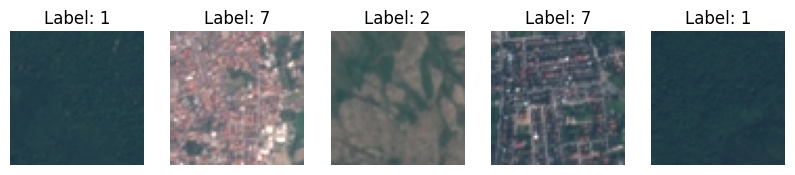

In [ ]:
sample_images, sample_labels = next(iter(data_train.take(1)))
fig, axes = plt.subplots(1, 5, figsize=(10, 2))
for i in range(5):
    axes[i].imshow(sample_images[i].numpy().astype("uint8"))
    axes[i].set_title(f"Label: {sample_labels[i].numpy()}")
    axes[i].axis("off")
plt.show()

### Train the model on training data  
The model is trained using the configured dataset and parameters.  
Training history is stored for later analysis and visualization.


In [ ]:
history = model.fit(data_train, validation_data=data_test, epochs=3)

Epoch 1/3
211/211 ━━━━━━━━━━━━━━━━━━━━ 213s 1s/step - accuracy: 0.8934 - loss: 0.3218 - val_accuracy: 0.9415 - val_loss: 0.1730
Epoch 2/3
211/211 ━━━━━━━━━━━━━━━━━━━━ 248s 1s/step - accuracy: 0.9157 - loss: 0.2436 - val_accuracy: 0.9466 - val_loss: 0.1546
Epoch 3/3
211/211 ━━━━━━━━━━━━━━━━━━━━ 210s 995ms/step - accuracy: 0.9224 - loss: 0.2321 - val_accuracy: 0.9518 - val_loss: 0.1437


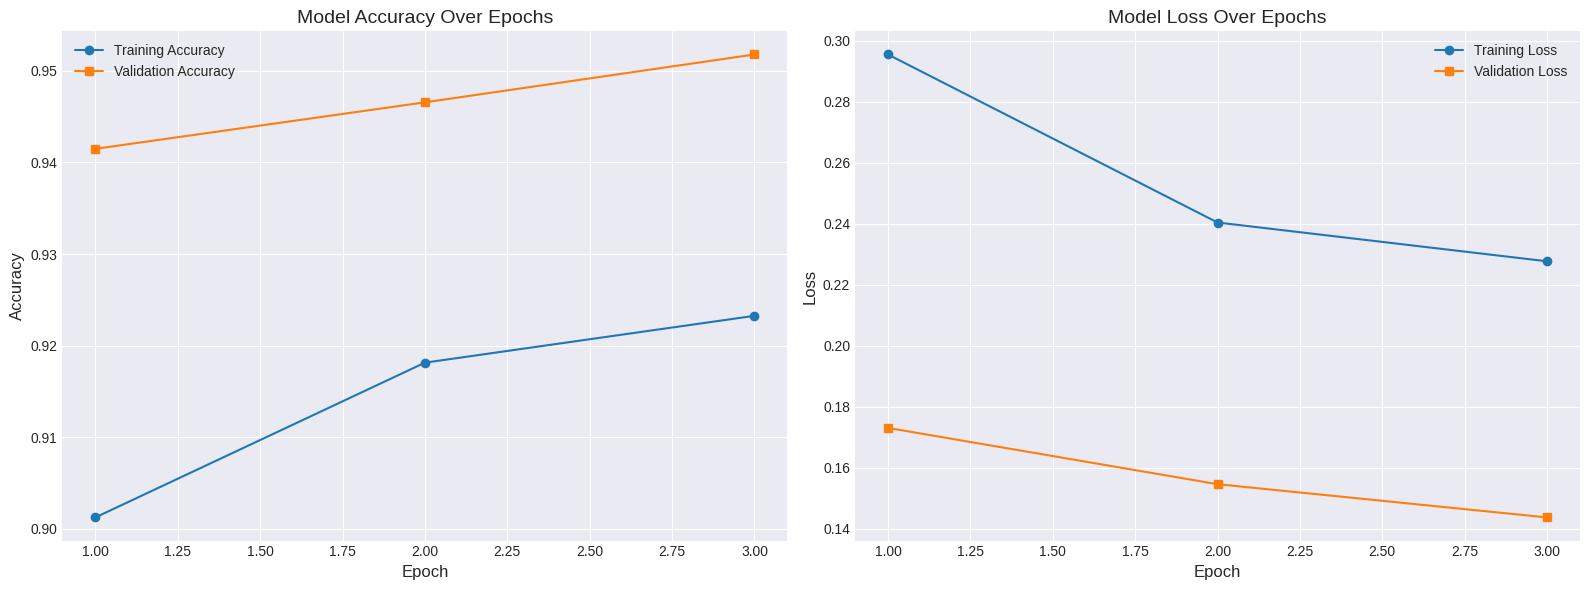

In [ ]:
import matplotlib.pyplot as plt

def plot_advanced_training_history(history):
    acc = history.history.get('accuracy', [])
    val_acc = history.history.get('val_accuracy', [])
    loss = history.history.get('loss', [])
    val_loss = history.history.get('val_loss', [])
    epochs = range(1, len(acc) + 1)

    # Use 'seaborn-v0_8-darkgrid' for compatibility with Seaborn >= 0.11
    plt.style.use('seaborn-v0_8-darkgrid')
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))

    # Plot Accuracy
    ax[0].plot(epochs, acc, marker='o', label='Training Accuracy')
    if val_acc:
        ax[0].plot(epochs, val_acc, marker='s', label='Validation Accuracy')
    ax[0].set_title('Model Accuracy Over Epochs', fontsize=14)
    ax[0].set_xlabel('Epoch', fontsize=12)
    ax[0].set_ylabel('Accuracy', fontsize=12)
    ax[0].legend()
    ax[0].grid(True)

    # Plot Loss
    ax[1].plot(epochs, loss, marker='o', label='Training Loss')
    if val_loss:
        ax[1].plot(epochs, val_loss, marker='s', label='Validation Loss')
    ax[1].set_title('Model Loss Over Epochs', fontsize=14)
    ax[1].set_xlabel('Epoch', fontsize=12)
    ax[1].set_ylabel('Loss', fontsize=12)
    ax[1].legend()
    ax[1].grid(True)

    plt.tight_layout()
    plt.show()

plot_advanced_training_history(history)